# Setup for Colab

In [1]:
!git clone https://github.com/zrmor/inverse_problem.git

%pip install pytorch_lightning python-dotenv

!python /content/inverse_problem/code/functions.py
!python /content/inverse_problem/code/models.py

import sys
sys.path.append('/content/inverse_problem/code')

fatal: destination path 'inverse_problem' already exists and is not an empty directory.
Note: you may need to restart the kernel to use updated packages.
python: can't open file '/content/inverse_problem/code/functions.py': [Errno 2] No such file or directory
python: can't open file '/content/inverse_problem/code/models.py': [Errno 2] No such file or directory


# Initial setup

In [2]:
import os
import numpy as np
import seaborn as sns
from getpass import getpass
from dotenv import load_dotenv
import matplotlib.pyplot as plt

import wandb
import pytorch_lightning as pl
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, confusion_matrix

from torch.utils.data import DataLoader
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import WandbLogger

from models import CNNClassifier, MatrixDataset

# Load and prepare data

In [3]:
# Load data
data_path = "../data/"

all_C = np.load(data_path + 'all_C.npy') # 1326 input matrices of size 30x30
# labels = np.load(data_path + 'nMF_labels.npy') # 1326 output labels (0 or 1)
labels = np.load(data_path + 'KMeans_labels_k3.npy') # 1326 output labels (0, 1 or 2)
# labels = np.load(data_path + 'KMeans_labels_k4.npy') # 1326 output labels (0, 1, 2 or 3)

print(f"Number of input C and output labels:\n {len(all_C)}, {len(labels)}\n")

Number of input C and output labels:
 1326, 1326



#### Only for kmean labels

In [4]:
# Remove C with zero kmean labels 
non_zero_indices = np.where(labels != 0)[0]
all_C = all_C[non_zero_indices]
labels = labels[non_zero_indices]

print(f"Number of Cs and labels after removing those with kmeans zero labels:\n {len(all_C)}, {len(labels)}\n")

Number of Cs and labels after removing those with kmeans zero labels:
 1325, 1325



In [5]:
# Replace values in labels 
labels[labels == 1] = 0  # Replace 1 with 0
labels[labels == 2] = 1  # Replace 2 with 1
# labels[labels == 3] = 2  # Replace 3 with 2

print(f"Updated labels: {np.unique(labels, return_counts=True)}")

Updated labels: (array([0, 1], dtype=int32), array([795, 530]))


#### For all labels

In [6]:
class_0_C = all_C[labels == 0] 
class_1_C = all_C[labels == 1] 
# class_2_C = all_C[labels == 2] 

print(f"Number of input matrices with kmeans label 0: {class_0_C.shape[0]}")
print(f"Number of input matrices with kmeans label 1: {class_1_C.shape[0]}")
# print(f"Number of input matrices with kmeans label 2: {class_2_C.shape[0]}")

Number of input matrices with kmeans label 0: 795
Number of input matrices with kmeans label 1: 530


# Training the Model

### Find the best params

In [7]:
# best_params_global = None

# # Load environment variables from .env file
# load_dotenv()

# # Get my API key from environment variable first
# wandb_key = os.getenv('WANDB_API_KEY')

# # If not found in environment, prompt user
# if not wandb_key:
#     wandb_key = getpass("Enter your Weights & Biases API key: ")

# wandb.login(key=wandb_key)

# # Define sweep configuration
# sweep_config = {
#     'method': 'grid', 
#     'name': 'sweep',
#     'metric': {
#         'goal': 'maximize',
#         'name': 'val_acc'
#     },
#     'parameters': {
#         'learning_rate': {
#             'values': [1e-5]
#         },
#         'conv_channels': {
#             'values': [[1, 32, 64, 128]]
#         },
#         'fc_units': {
#             # 'values': [[1152, 128, 2]]
#             'values': [[1152, 128, 3]]
#         },
#         'dropout_rate': {
#             'values': [0.5]
#         },
#         'batch_size': {
#             'values': [128]
#         }
#     }
# }

# # Initialize sweep
# sweep_id = wandb.sweep(sweep=sweep_config, project="inverse_problem")

# # Function to find the best parameters using kfold validation 
# def find():
    
#     wandb.init()
#     # Get sweep parameters
#     config = wandb.config
     
#     global best_params_global
    
#     # First split into train+val and test sets (80-20 split)
#     X_trainval, X_test, y_trainval, y_test = train_test_split(
#         all_C, labels, test_size=0.2, random_state=42, stratify=labels
#     )

#     # K-fold setup for cross-validation on training data
#     kfold = KFold(n_splits=5, shuffle=True, random_state=42)

#     # Grid search with k-fold cross validation
#     best_val_acc = 0

#     print("Data split sizes:")
#     print(f"Train + Validation: {len(X_trainval)} samples")
#     print(f"Test: {len(X_test)} samples\n")

#     print("Starting grid search with k-fold cross validation")

#     # K-fold cross validation
#     for fold, (train_idx, val_idx) in enumerate(kfold.split(X_trainval)):
#         print(f"\nFold {fold+1}/{kfold.n_splits}")
        
#         # Prepare data for this fold
#         X_train, X_val = X_trainval[train_idx], X_trainval[val_idx]
#         y_train, y_val = y_trainval[train_idx], y_trainval[val_idx]
        
#         train_dataset = MatrixDataset(X_train, y_train)
#         val_dataset = MatrixDataset(X_val, y_val)
        
#         train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)
#         val_loader = DataLoader(val_dataset, batch_size=config.batch_size)
        
#         # Initialize model and trainer
#         model = CNNClassifier(
#             learning_rate=config.learning_rate,
#             conv_channels=config.conv_channels,
#             fc_units=config.fc_units,
#             dropout_rate=config.dropout_rate
#         )
        
#         checkpoint_callback = ModelCheckpoint(
#             monitor='val_acc',
#             dirpath='checkpoints/',
#             filename=f'fold{fold}_lr{config.learning_rate:.4f}_conv{config.conv_channels}_fc{config.fc_units}_dropout{config.dropout_rate:.2f}_batch{config.batch_size}.ckpt',
#             save_top_k=1,
#             mode='max'
#         )
        
#         trainer = pl.Trainer(
#             max_epochs=100,
#             logger=WandbLogger(project="inverse_problem"),
#             callbacks=[checkpoint_callback],
#             accelerator='auto',
#             log_every_n_steps=1
#         )

#         # Train model
#         print("Training model...")
#         trainer.fit(model, train_loader, val_loader)
        
#         fold_score = checkpoint_callback.best_model_score.item()
#         print(f"Fold {fold+1} best validation accuracy: {fold_score:.4f}")

#         # Update best parameters if necessary
#         if fold_score > best_val_acc:
#             best_val_acc = fold_score
#             best_params_global = {
#                 'learning_rate': config.learning_rate,
#                 'conv_channels': config.conv_channels,
#                 'fc_units': config.fc_units,
#                 'dropout_rate': config.dropout_rate,
#                 'batch_size': config.batch_size
#             }
#             print("\n🌟 New best model found!")
#             print(f"Best validation accuracy so far: {best_val_acc:.4f}")

#     wandb.finish()
#     print("\nFinished wandb run for kfold validation.")

# # Start the sweep for kfold validation
# wandb.agent(sweep_id, function=find, count=1) 
# wandb.finish()

### Final training on the whole dataset with the best params

In [8]:
# Best params
best_params_global = {
        'learning_rate': 1e-5,
        'conv_channels': [1, 32, 64, 128],
        'fc_units': [1152, 128, 2],
        # 'fc_units': [1152, 128, 3],
        'dropout_rate': 0.5,
        'batch_size': 128
        }

In [9]:
labels_name = "k2means"

# Split the data into train+val and test sets
X_trainval, X_test, y_trainval, y_test = train_test_split(
        all_C, labels, test_size=0.2, random_state=42, stratify=labels
    )
print(f"Number of training + validation samples: {len(X_trainval)}")
print(f"Number of testing samples: {len(X_test)}\n")

# K-fold setup for cross-validation on training data
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize lists to store metrics for each fold
fold_accuracies = []
all_y_val_true = []
all_y_val_pred = []

# K-fold cross-validation
for fold, (train_idx, val_idx) in enumerate(kfold.split(X_trainval)):
    print(f"\nFold {fold + 1}/{kfold.n_splits}")

    # Prepare data for this fold
    X_train, X_val = X_trainval[train_idx], X_trainval[val_idx]
    y_train, y_val = y_trainval[train_idx], y_trainval[val_idx]

    # Log the number of samples for train and validation sets
    print(f"Number of training samples: {len(X_train)}")
    print(f"Number of validation samples: {len(X_val)}\n")

    train_dataset = MatrixDataset(X_train, y_train)
    val_dataset = MatrixDataset(X_val, y_val)

    train_loader = DataLoader(train_dataset, batch_size=best_params_global['batch_size'], shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=best_params_global['batch_size'])

    # Define the model for this fold
    model = CNNClassifier(
        learning_rate=best_params_global['learning_rate'],
        conv_channels=best_params_global['conv_channels'],
        fc_units=best_params_global['fc_units'],
        dropout_rate=best_params_global['dropout_rate']
    )

    wandb.init(project="inverse_problem", tags=[labels_name])

    trainer = pl.Trainer(
        max_epochs=300,
        logger=WandbLogger(project="inverse_problem"),
        accelerator='auto',
        log_every_n_steps=5
    )

    # Train the final model with validation
    trainer.fit(model, train_loader, val_loader)

    # Collect true labels and predictions for this fold
    y_val_pred = model.predict(val_loader)
    all_y_val_true.extend(y_val)  # Collect true labels from validation set
    all_y_val_pred.extend(y_val_pred)  # Collect predictions from validation set

    # Get final validation accuracy for this fold
    fold_accuracy = trainer.test(model, val_loader)[0]['test_acc']
    fold_accuracies.append(fold_accuracy)
    wandb.log({"labels": labels_name, "fold": fold})

    # Calculate and log average accuracy across all folds
    average_fold_accuracy = np.mean(fold_accuracies)
    wandb.log({"average_fold_accuracy": average_fold_accuracy})
    print(f"\nAverage validation accuracy across folds up to now: {average_fold_accuracy:.4f}")

    wandb.finish()

print("Start the final training on train + validation set...")
# After completing all folds, evaluate on the test set
test_dataset = MatrixDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=best_params_global['batch_size'])

# Combine all training and validation data for final training
trainval_dataset = MatrixDataset(X_trainval, y_trainval)
trainval_loader = DataLoader(trainval_dataset, batch_size=best_params_global['batch_size'], shuffle=True)

# Define the model for this fold
final_model = CNNClassifier(
    learning_rate=best_params_global['learning_rate'],
    conv_channels=best_params_global['conv_channels'],
    fc_units=best_params_global['fc_units'],
    dropout_rate=best_params_global['dropout_rate']
)

wandb.init(project="inverse_problem", tags=["final_test", labels_name])

final_trainer = pl.Trainer(
    max_epochs=300,
    logger=WandbLogger(project="inverse_problem"),
    accelerator='auto',
    log_every_n_steps=5
)

# Train the final model on the combined dataset
final_trainer.fit(final_model, trainval_loader)

# Evaluate on the test set
test_results = final_trainer.test(final_model, test_loader)

# Collect predictions for the test set
y_test_pred = final_model.predict(test_loader) 
y_test_true = y_test

# Log test results
wandb.log({"test_accuracy": test_results[0]['test_acc']})
print(f"Final test accuracy, after training on train + validation set: {test_results[0]['test_acc']:.4f}")

wandb.finish()
print("\nFinished wandb run")

Number of training + validation samples: 1060
Number of testing samples: 265


Fold 1/5
Number of training samples: 848
Number of validation samples: 212



wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: zrmor (personlich). Use `wandb login --relogin` to force relogin


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/zahra/anaconda3/envs/inverse_problem/lib/python3.11/site-packages/pytorch_lightning/loggers/wandb.py:396: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.

  | Name        | Type       | Params | Mode 
---------------------------------------------------
0 | conv_layers | Sequential | 93.1 K | train
1 | fc_layers   | Sequential | 147 K  | train
---------------------------------------------------
240 K     Trainable params
0         Non-trainable params
240 K     Total params
0.964     Total estimated model params size (MB)
20        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/zahra/anaconda3/envs/inverse_problem/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


/Users/zahra/anaconda3/envs/inverse_problem/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Epoch 299: 100%|██████████| 7/7 [00:01<00:00,  3.62it/s, v_num=zgtf]

`Trainer.fit` stopped: `max_epochs=300` reached.


Epoch 299: 100%|██████████| 7/7 [00:01<00:00,  3.56it/s, v_num=zgtf]


/Users/zahra/anaconda3/envs/inverse_problem/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 2/2 [00:00<00:00,  9.83it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9622641801834106
        test_loss           0.08137019723653793
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Average validation accuracy across folds up to now: 0.9623


average_fold_accuracy,▁
epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▇▇▇▇████
fold,▁
test_acc,▁
test_loss,▁
train_acc_epoch,▁▄▅▅▆▆▇▇▇▇▇▇▇███████████████████████████
train_acc_step,▁▅▅▆▇▇▇▇▇█████▇█████████████████████████
train_loss_epoch,█▆▆▅▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss_step,██▇▄▄▃▃▃▃▃▂▃▃▂▂▂▂▁▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▂▁▁▁▁▁
trainer/global_step,▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇███
val_acc,▁▁▃▅▆▆▆▇▇▇▇█████████████████████████████



Fold 2/5
Number of training samples: 848
Number of validation samples: 212



GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/zahra/anaconda3/envs/inverse_problem/lib/python3.11/site-packages/pytorch_lightning/loggers/wandb.py:396: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.

  | Name        | Type       | Params | Mode 
---------------------------------------------------
0 | conv_layers | Sequential | 93.1 K | train
1 | fc_layers   | Sequential | 147 K  | train
---------------------------------------------------
240 K     Trainable params
0         Non-trainable params
240 K     Total params
0.964     Total estimated model params size (MB)
20        Modules in train mode
0         Modules in eval mode


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

/Users/zahra/anaconda3/envs/inverse_problem/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


/Users/zahra/anaconda3/envs/inverse_problem/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Epoch 299: 100%|██████████| 7/7 [00:01<00:00,  3.67it/s, v_num=93fu]

`Trainer.fit` stopped: `max_epochs=300` reached.


Epoch 299: 100%|██████████| 7/7 [00:01<00:00,  3.54it/s, v_num=93fu]


/Users/zahra/anaconda3/envs/inverse_problem/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 2/2 [00:00<00:00,  3.80it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9764150977134705
        test_loss           0.06875047832727432
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Average validation accuracy across folds up to now: 0.9693


average_fold_accuracy,▁
epoch,▁▁▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█
fold,▁
test_acc,▁
test_loss,▁
train_acc_epoch,▁▂▄▅▅▆▆▇▇▇▇█▇███████████████████████████
train_acc_step,▁▅▆▇▇▇▇███▇█▇███████████████████████████
train_loss_epoch,█▇▇▆▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss_step,█▄▅▅▅▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▁▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇██
val_acc,▁▃▆▇████████████████████████████████████



Fold 3/5
Number of training samples: 848
Number of validation samples: 212



GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/zahra/anaconda3/envs/inverse_problem/lib/python3.11/site-packages/pytorch_lightning/loggers/wandb.py:396: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.

  | Name        | Type       | Params | Mode 
---------------------------------------------------
0 | conv_layers | Sequential | 93.1 K | train
1 | fc_layers   | Sequential | 147 K  | train
---------------------------------------------------
240 K     Trainable params
0         Non-trainable params
240 K     Total params
0.964     Total estimated model params size (MB)
20        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/zahra/anaconda3/envs/inverse_problem/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


/Users/zahra/anaconda3/envs/inverse_problem/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Epoch 299: 100%|██████████| 7/7 [00:06<00:00,  1.12it/s, v_num=i71o]

`Trainer.fit` stopped: `max_epochs=300` reached.


Epoch 299: 100%|██████████| 7/7 [00:06<00:00,  1.11it/s, v_num=i71o]


/Users/zahra/anaconda3/envs/inverse_problem/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 2/2 [00:00<00:00,  6.61it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9669811129570007
        test_loss           0.0610029399394989
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Average validation accuracy across folds up to now: 0.9686


average_fold_accuracy,▁
epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇████
fold,▁
test_acc,▁
test_loss,▁
train_acc_epoch,▁▃▆▇▇▇▇▇▇███████████████████████████████
train_acc_step,▁▄▃▄▇▆▇▇▇███▇███▇█████████████▇█████▇███
train_loss_epoch,██▅▅▅▄▃▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss_step,▇█▇▅▅▃▃▃▃▃▂▂▂▂▂▂▂▁▂▁▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▇████
val_acc,▁▂▄▇▇▇██████████████████████████████████



Fold 4/5
Number of training samples: 848
Number of validation samples: 212



GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/zahra/anaconda3/envs/inverse_problem/lib/python3.11/site-packages/pytorch_lightning/loggers/wandb.py:396: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.

  | Name        | Type       | Params | Mode 
---------------------------------------------------
0 | conv_layers | Sequential | 93.1 K | train
1 | fc_layers   | Sequential | 147 K  | train
---------------------------------------------------
240 K     Trainable params
0         Non-trainable params
240 K     Total params
0.964     Total estimated model params size (MB)
20        Modules in train mode
0         Modules in eval mode


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

/Users/zahra/anaconda3/envs/inverse_problem/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


/Users/zahra/anaconda3/envs/inverse_problem/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Epoch 299: 100%|██████████| 7/7 [00:01<00:00,  3.91it/s, v_num=85xn]

`Trainer.fit` stopped: `max_epochs=300` reached.


Epoch 299: 100%|██████████| 7/7 [00:01<00:00,  3.83it/s, v_num=85xn]


/Users/zahra/anaconda3/envs/inverse_problem/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 2/2 [00:00<00:00,  9.27it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9622641801834106
        test_loss           0.06649157404899597
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Average validation accuracy across folds up to now: 0.9670


average_fold_accuracy,▁
epoch,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇████
fold,▁
test_acc,▁
test_loss,▁
train_acc_epoch,▁▅▅▅▅▇▇▇████████████████████████████████
train_acc_step,▁▁▄▄▅▇▇██▇▇█████████████████████████████
train_loss_epoch,█▅▅▅▅▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss_step,█▆▆▆▅▅▄▄▄▃▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
val_acc,▁▅▅▆▇▇██████████████████████████████████



Fold 5/5
Number of training samples: 848
Number of validation samples: 212



GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/zahra/anaconda3/envs/inverse_problem/lib/python3.11/site-packages/pytorch_lightning/loggers/wandb.py:396: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.

  | Name        | Type       | Params | Mode 
---------------------------------------------------
0 | conv_layers | Sequential | 93.1 K | train
1 | fc_layers   | Sequential | 147 K  | train
---------------------------------------------------
240 K     Trainable params
0         Non-trainable params
240 K     Total params
0.964     Total estimated model params size (MB)
20        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/zahra/anaconda3/envs/inverse_problem/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


/Users/zahra/anaconda3/envs/inverse_problem/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Epoch 299: 100%|██████████| 7/7 [00:02<00:00,  2.70it/s, v_num=9aug]

`Trainer.fit` stopped: `max_epochs=300` reached.


Epoch 299: 100%|██████████| 7/7 [00:02<00:00,  2.63it/s, v_num=9aug]


/Users/zahra/anaconda3/envs/inverse_problem/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 2/2 [00:00<00:00,  4.11it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9669811129570007
        test_loss          0.061716072261333466
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Average validation accuracy across folds up to now: 0.9670


average_fold_accuracy,▁
epoch,▁▁▁▁▁▂▂▂▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇█████
fold,▁
test_acc,▁
test_loss,▁
train_acc_epoch,▁▃▅▆▆▆▆▇▇▇▇▇▇▇█▇███▇████████████████████
train_acc_step,▁▇▇▇▇▇██████████▇███████████████████▇███
train_loss_epoch,█▆▅▅▅▄▄▃▃▂▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss_step,██▇▅▆▅▄▃▃▃▂▂▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇██
val_acc,▁▆▆▆▆▆▇█████████████████████████████████


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/zahra/anaconda3/envs/inverse_problem/lib/python3.11/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/Users/zahra/anaconda3/envs/inverse_problem/lib/python3.11/site-packages/pytorch_lightning/loggers/wandb.py:396: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.

  | Name        | Type       | Params | Mode 
---------------------------------------------------
0 | conv_layers | Sequential | 93.1 K | train
1 | fc_layers   | Sequential | 147 K  | train
---------------------------------------------------
240 K     Trainable params
0         Non-trainable params
240 K     Total params
0.964     Total estimated model params size (MB)
20 

Epoch 299: 100%|██████████| 9/9 [00:02<00:00,  3.62it/s, v_num=fimh]

`Trainer.fit` stopped: `max_epochs=300` reached.


Epoch 299: 100%|██████████| 9/9 [00:02<00:00,  3.57it/s, v_num=fimh]

/Users/zahra/anaconda3/envs/inverse_problem/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.



Testing DataLoader 0: 100%|██████████| 3/3 [00:00<00:00,  4.59it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9698113203048706
        test_loss           0.08293703943490982
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Final test accuracy, after training on train + validation sets: 0.9698


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇█████
test_acc,▁
test_accuracy,▁
test_loss,▁
train_acc_epoch,▁▅▅▅▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇█████████████████████
train_acc_step,▁▄▃▅▅█▇█▇███▇█▇█████████████████████████
train_loss_epoch,█▄▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss_step,█▅▅▅▄▂▂▂▂▂▂▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▁▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇███
epoch,300
test_acc,0.96981



Finished wandb run


# Model Evaluation

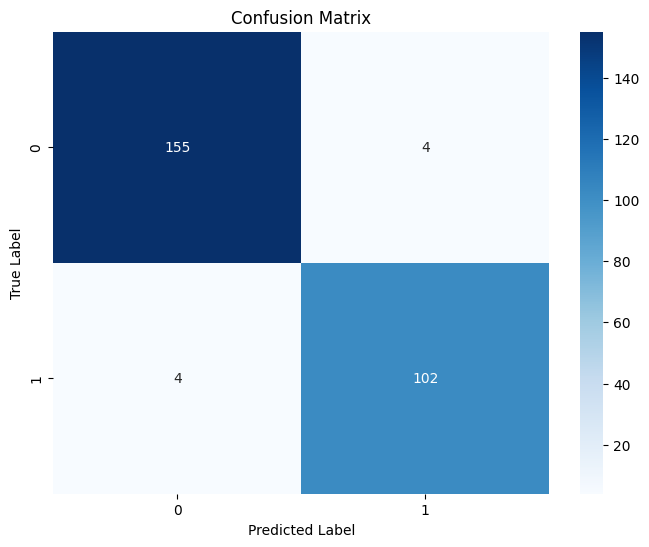

In [11]:
# Confusion Matrix
cm = confusion_matrix(y_test_true, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test_true), yticklabels=np.unique(y_test_true))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
# plt.savefig('../docs/nMF_confusion.png')
plt.savefig('../docs/k2means_confusion.png')
# plt.savefig('../docs/k3means_confusion.png')
plt.show()

### For binary class

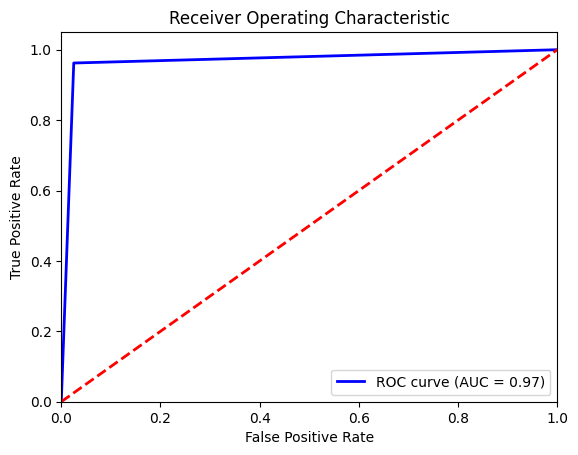

Average Precision score: 0.9410


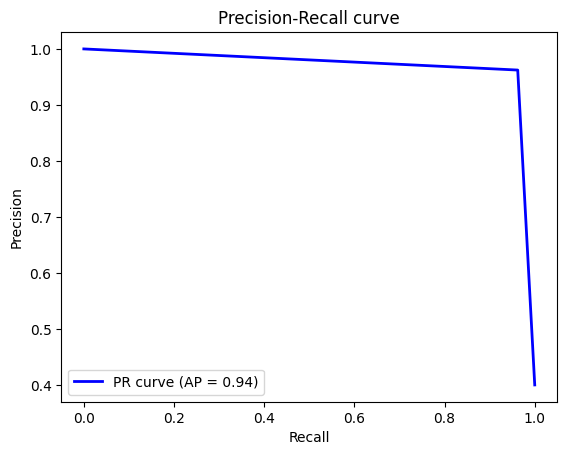

In [12]:
# ROC Curves
fpr, tpr, _ = roc_curve(y_test_true, y_test_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
# plt.savefig('../docs/nMF_roc.png')
plt.savefig('../docs/k2means_roc.png')
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test_true, y_test_pred)

ap_score = average_precision_score(y_test_true, y_test_pred)
print(f"Average Precision score: {ap_score:.4f}")

plt.figure()
plt.plot(recall, precision, color='blue', lw=2, label='PR curve (AP = %0.2f)' % ap_score)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc="lower left") 
# plt.savefig('../docs/nMF_pr.png')
plt.savefig('../docs/k2means_pr.png')
plt.show()


### For multi class

In [ ]:
# ROC Curve

# Binarize the output for multi-class ROC
y_true_bin = label_binarize(y_test_true, classes=[0, 1, 2])
y_pred_bin = label_binarize(y_test_pred, classes=[0, 1, 2])

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):  # For each class
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
for i in range(3):
    plt.plot(fpr[i], tpr[i], lw=2, label='ROC curve class {0} (AUC = {1:0.2f})'.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Multi-Class')
plt.legend(loc="lower right")
plt.savefig('../docs/k3means_roc.png')
plt.show()


# Precision-Recall Curve
precision = dict()
recall = dict()
ap_score = dict()
for i in range(3):  # For each class
    precision[i], recall[i], _ = precision_recall_curve(y_true_bin[:, i], y_pred_bin[:, i])
    ap_score[i] = average_precision_score(y_true_bin[:, i], y_pred_bin[:, i])
    plt.plot(recall[i], precision[i], lw=2, label='PR curve class {0} (AP = {1:0.2f})'.format(i, ap_score[i]))

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve for Multi-Class')
plt.legend(loc="lower left") 
plt.savefig('../docs/k3means_pr.png')
plt.show()